In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import random
import cv2
import sys
import time
sys.path.insert(0, 'py_scripts/')

import torch
from Image_Sampler import Sampler
from env_carla import Environment
from model_eval import Evaluater
from AE_model import AutoEncoder
from ScenarioPlanner import ScenarioPlanner
from scenario_env import ScenarioEnvironment

In [ ]:
a = {"1", "2"}



# Sampling Section

In [2]:
planner = ScenarioPlanner(s_width=2048, s_height=2048, cam_height=20.5, cam_zoom=130, cam_rotation=-70, cam_x_offset=18.)
planner.sampleScenariosSet(10)


~~~~~~~~~~~~~~
# Collecting 10 scenarios among world: Town01_Opt 
~~~~~~~~~~~~~~


FileNotFoundError: [Errno 2] No such file or directory: 'anomaly_list.json'

In [ ]:
# sampler = Sampler(s_width=100, s_height=100, cam_height=4, cam_zoom=50, cam_rotation=-18)
sampler = Sampler(s_width=256, s_height=256, cam_height=4.5, cam_zoom=130, cam_rotation=-90) #top-down
# sampler = Sampler(s_width=2048, s_height=2048, cam_height=20.5, cam_zoom=130, cam_rotation=-70, cam_x_offset=18.) #top-down
sampler.show_Example()

In [ ]:
ScenarioPlanner.create_final_json("/disk/vanishing_data/is789/scenario_samples/Set_2023-02-07_16:36/")

In [ ]:
ScenarioPlanner.create_snap_video(storagePath="/disk/vanishing_data/is789/scenario_samples/Set_2023-02-07_16:36/", max_scenes=10)

In [ ]:
ScenarioPlanner.createComparison("/disk/vanishing_data/is789/scenario_samples/Set_2022-12-14_00:59/")

In [ ]:
img1 = cv2.imread("/disk/vanishing_data/is789/scenario_samples/Set_2023-02-07_16:36/snapshots/snap_7013.png")
plt.imshow(img1)

In [ ]:
x = [1,2,3]

y = x[1]
y += 5

x

In [ ]:
img, _ = sampler.sample(random_spawn=True)
plt.imshow(img)

# img = (img * 255).astype("int")
# cv2.imwrite("anomayl_samples/11.png",img) 

In [ ]:
from PIL import Image
k = (img * 255).astype(np.uint8)
im = Image.fromarray(k, "RGB")
im.save("your_file.jpeg")

In [ ]:
img.shape

In [ ]:
# test = cv2.imread("anomayl_samples/1.png")
# plt.imshow(test)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae_model = AutoEncoder()
path = "py_scripts/model.pt"
ae_model.to(device)
ae_model.load_state_dict(torch.load(path))
eval = Evaluater(ae_model, device)

Image Flow:
Encoder:
256x256x3 (Input Image)
256x256x64
127x127x120
63x63x240
31x31x480
15x15x512
Decoder:
15x15x512
15x15x512
31x31x256
63x63x128
127x127x64
256x256x3 (Output Image)


In [3]:
images = Sampler.load_Images("anomayl_samples/").astype("float32") / 255

Loaded 12 images | width = 256, height = 256, channels = 3


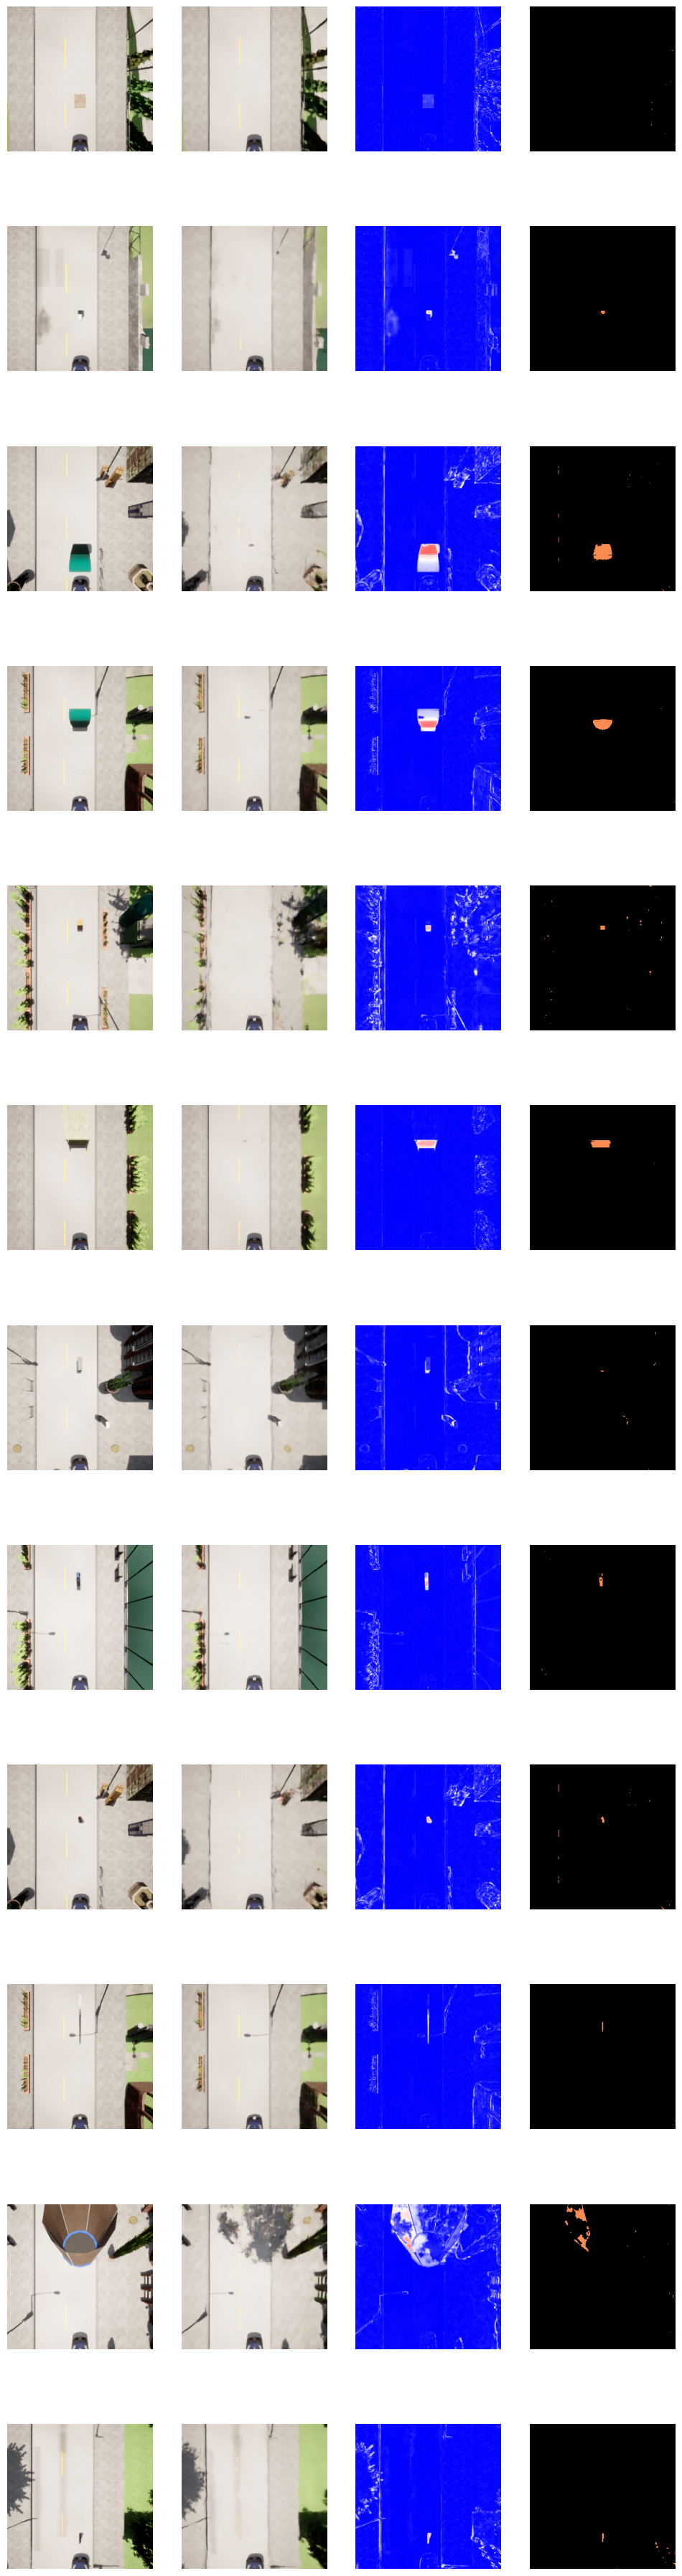

In [4]:
fig, axe = plt.subplots(len(images), 4, figsize=(12, len(images)*4), dpi=100)
for x in range(len(images)):
    img = images[x]
    gt, out = eval.predict(img)
    hm = eval.getHeatMap(img)
    dt = eval.getColoredDetectionMap(img)
    # gt = (gt).astype("uint8")
    # out = (out).astype("uint8")
    # dt = (dt).astype("uint8")


    axe[x,0].imshow(gt)
    axe[x,0].axis('off')
    axe[x,1].imshow(out)
    axe[x,1].axis('off')    
    axe[x,2].imshow(hm)
    axe[x,2].axis('off')
    axe[x,3].imshow(dt)
    axe[x,3].axis('off')

# plt.tight_layout()
plt.show()
# plt.axes("off")

In [ ]:
def introPic(images):
    final_img = []
    seperator = np.zeros((256, 2, 3))
    # seperator[:,:,0] = 1.
    seperatorH = np.zeros((2, 772, 3))
    # seperatorH[:,:,0] = 1.
    for x in range(len(images)):
        img = images[x]
        plt.imsave(f"paper_plots/input{x}.png", img)
        gt, out = eval.predict(img)
        plt.imsave(f"paper_plots/output{x}.png", out)
        hm = eval.getHeatMap(img)
        plt.imsave(f"paper_plots/heatmap{x}.png", hm)
        dt = eval.getColoredDetectionMap(img)
        plt.imsave(f"paper_plots/anomaly_map{x}.png", dt)

        fusion = np.hstack((img, seperator, out, seperator,  hm))
        final_img.append(fusion)
        print(fusion.shape)
        plt.imsave("paper_plots/introPic.png", fusion)
        plt.imshow(fusion)
        plt.show()
    
    combImg = final_img[0]
    for x in range(1,len(final_img)):
        combImg = np.vstack((combImg, seperatorH, final_img[x]))
    plt.imsave("paper_plots/combPic.png", combImg)
    plt.imshow(combImg)


introPic([images[3], images[4]])

In [ ]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    k = modified_z_score > thresh
    p = np.zeros((len(points)))
    for x in range(len(p)):
        if k[x] == True:
            p[x] = 1.0
    return p

In [ ]:
from sklearn.cluster import KMeans

y = np.array([1, 2, 3, 3, 2, 25, 24, 22, 88, 50])#.reshape(-1, 1)
# kmeans = KMeans(n_clusters=2)
# a = kmeans.fit(y)

In [ ]:
is_outlier(y)

In [ ]:
z = a.labels_ * -1 + 1
z

In [ ]:
a.cluster_centers_[1][0]

In [ ]:
imgs, _ = sampler.sample_Ride(num_of_snaps=41)

for x in range(0,40):
    plt.imshow(imgs[x])
    plt.show()

In [ ]:
# sampler = Sampler(s_width=256, s_height=256, cam_height=4, cam_zoom=50, cam_rotation=-12)
sampler = Sampler(s_width=256, s_height=256, cam_height=4.5, cam_zoom=130, cam_rotation=-90)

In [ ]:
waypoints, wp, sl = sampler.get_waypoints()

In [ ]:
wp.lane_id

In [ ]:
pp = []
for xx in waypoints:
    p = [xx.transform.location.x, xx.transform.location.y]
    pp.append(np.array(p))
pp = np.array(pp)
pp = pp.T

In [ ]:
plt.figure(figsize=(10, 10), dpi=80)
plt.plot(pp[0,:], pp[1,:], '.k', alpha=1, ms=0.5)
plt.plot(wp.transform.location.x, wp.transform.location.y, '.r', alpha=1, ms=10.5)

In [ ]:
front = [[wp]]
root = wp
for x in range(100):
    front.append(front[-1][0].next(2.))

In [ ]:
k = wp.next(20.)

In [ ]:
k[0].

In [ ]:
vehicle_location = wp.transform.location
front = []
for xx in sl:
    waypoint_location = xx.transform.location
    if (waypoint_location - vehicle_location).x > 0:
        front.append(xx)

In [ ]:
pp = []
for x in range(len(front)):
    xx = front[x][0]
    p = [xx.transform.location.x, xx.transform.location.y]
    pp.append(np.array(p))
pp = np.array(pp)
pp = pp.T

plt.figure(figsize=(10, 10), dpi=80)
plt.plot(pp[0,:], pp[1,:], '.k', alpha=1, ms=0.5)
plt.plot(wp.transform.location.x, wp.transform.location.y, '.r', alpha=1, ms=10.5)

In [ ]:
img, seg = sampler.sample()

In [ ]:
sampler.show_Example(random_spawn=True, segmentation=False)

In [ ]:
seg[0]

In [ ]:
mask = np.zeros((512,512,3))
for x in range(len(seg)):
    for y in range(len(seg[x])):
        chunk = seg[x][y][0]
        if chunk == 7:
            mask[x][y][0] = 1
            print("sgf")
        if chunk == 8:
            mask[x][y][2] = 1

In [ ]:
plt.imshow(img)

In [ ]:
mask = mask.astype("float32")

In [ ]:
plt.imshow(mask)

In [ ]:
mask[0]

In [ ]:
images, seg = sampler.sample_Ride(world_model="Town01_Opt", num_of_snaps=10, tick_rate=1, anomaly=True)

In [ ]:
for img in images:
    plt.imshow(img)
    plt.show()

In [ ]:
seg[9][250][250]

In [ ]:
plt.imshow(images[9])

# Loading Section

In [ ]:
images = Sampler.load_Images("/disk/vanishing_data/is789/anomaly_samples/paper_data_set/", size=40)

In [ ]:
images = images[:,:,:,:3]

In [ ]:
images[0].shape

In [ ]:
paths = Sampler.get_image_paths("/disk/vanishing_data/is789/anomaly_samples/Samples_2022-11-03_20:07:27/")

In [ ]:
for x in range(0,30):
    plt.imshow(images[x])
    plt.show()

In [ ]:
Sampler.sample_from_Set(images)

In [ ]:
plt.imshow(images[4])

In [ ]:
def process_image(image):
    "Processes the image"
    image.resize((256, 256), Image.ANTIALIAS) # or whatever you are doing to the image
    return image

In [ ]:
xx = process_image(images[0])

In [ ]:
img = np.array(images[10])
plt.imshow(img)

In [ ]:
recon = np.array(img)
recon[250:310,200:350,:] = 0.0
plt.imshow(recon)

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [ ]:
g1 = rgb2gray(img)
g2 = rgb2gray(recon)
g3 = abs(g1-g2)

In [ ]:
g3 = g3.astype("float32") /255

In [ ]:
hm = np.zeros((512,512,3))
hm = hm.astype("float32")
for x in range(len(hm)):
    for y in range(len(hm[x])):
        if g3[x][y] < 0.5:
            hm[x][y][2] = 1
            hm[x][y][1] = 2*g3[x][y]
            hm[x][y][0] = 2*g3[x][y]
        else:
            hm[x][y][0] = 1
            hm[x][y][1] = 1 - 2*(g3[x][y] - 0.5)
            hm[x][y][2] = 1 - 2*(g3[x][y] - 0.5)
#         hm[x][y][2] = 1 - 2*g3[x][y]
#         if hm[x][y][2] < 0.:
#             hm[x][y][2] = 0.
#             hm[x][y][0] = 2*g3[x][y]

In [ ]:
bar = np.zeros((450,50,3))
ll = np.linspace(0,1,450)
for y in range(len(bar)):
    if ll[y] < 0.5:
        bar[y,:,2] = 1
        bar[y,:,1] = 2*ll[y]
        bar[y,:,0] = 2*ll[y]
    else:
        bar[y,:,2] = 1 - 2*(ll[y] - 0.5)
        bar[y,:,1] = 1 - 2*(ll[y] - 0.5)
        bar[y,:,0] = 1
        
bar[bar > 0.99] = 0.99
padd = np.zeros((31,50,3)) + 1.0
bar = np.vstack((padd, bar, padd))

In [ ]:
plt.imshow(bar)
plt.axis("off")

In [ ]:
padding = np.zeros((512,35,3)).astype("float32")
padding = padding + 1.0

In [ ]:
heatmap = np.hstack((hm,padding,bar))
plt.imshow(heatmap)

In [ ]:
errorMatrix = (img - recon)
errorAvg = np.sum(errorMatrix) / (errorMatrix.shape[0] * errorMatrix.shape[1] * errorMatrix.shape[2])
errorAvg = int(errorAvg * 100000)/ 100000.0

In [ ]:
err = np.linspace(0,1,10)

from matplotlib.pyplot import figure

figure(figsize=(5.12, 5.12), dpi=100)
plt.plot(err, lw=3)
plt.xlim(-5, 140)
plt.savefig("heatmap.png")

In [ ]:
def test():
    
    fig = plt.figure(figsize=(5.12, 4.12), dpi=100) # this is imp for sizing
    # plot
    plt.plot(err, color="black")
    # get image as np.array
    canvas = plt.gca().figure.canvas
    canvas.draw()
    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    image = data.reshape(canvas.get_width_height()[::-1] + (3,))
    print(type(image[0][0][0]))
    cv2.imwrite("test.png", image)
    return image

In [ ]:
aa = []
for x in range(1):
    aa.append(test())

In [ ]:
plt.imshow(aa[3])

In [ ]:
fig.clear()

In [ ]:
image.shape

In [ ]:
import cv2
kk = np.array(cv2.imread("heatmap.png"))
kk.shape

In [ ]:
import seaborn as sb
figure(figsize=(5.12, 5.12), dpi=100)
hm = sb.heatmap(g3, xticklabels=False, yticklabels=False)
plt.savefig("heatmap.png", bbox_inches='tight', pad_inches = 0)

In [ ]:
kk = cv2.imread("heatmap.png")
plt.imshow(kk)

In [ ]:
kk.shape

In [ ]:
image_index = 1828
storagePath = "/disk/vanishing_data/is789/anomaly_samples/2500train/"

In [ ]:
import cv2
images = np.array(images)
images = (images * 255).astype("int")
for k in range(len(images)):
    cv2.imwrite(storagePath + f"snap_{image_index}.png", images[k]) 
    # plt.imsave(storagePath + f"snap_{image_index}.png",images[k], format="png")
    image_index = image_index + 1

In [ ]:
def convert_pic_to_row(pic):
    output = []
    for col in(pic):
        temp = []
        for x in range(len(col)):
            row = col[x]
            temp = np.concatenate((temp,row), axis=None)
        output = np.concatenate((output,temp), axis=None)

    result = np.array(output)
    result = result.astype(int)
    return result

In [ ]:
import csv

f = open("./test.csv", 'w')

with f:

    writer = csv.writer(f)
    
    for image in images:
        image = convert_pic_to_row(image)
        writer.writerow(image)

In [ ]:
test = convert_pic_to_row(images[0])
test

In [ ]:
import cv2 

In [ ]:
images = np.array(images)

In [ ]:
k = (images * 255).astype("int")

In [ ]:
import PIL


In [ ]:
cv2.imwrite("test.png", k[10]) 

In [ ]:
img = cv2.imread("test.png")

In [ ]:
plt.imshow(img)

In [ ]:

def load_img_csv(path): 
    f = open("./test.csv", 'r')

    loaded_state = []
    result = []


    with f:

        reader = csv.reader(f)

        for row in reader:
            temp = []
            for e in row:
                temp.append(e)
            loaded_state.append(temp)

    return loaded_state

In [ ]:
kappa = load_img_csv("s")

In [ ]:
matrix = np.eye(256, 256, dtype=np.uint8)*255
matrix = np.concatenate((np.atleast_3d(matrix), np.zeros((256, 256, 2), dtype=np.uint8)), axis=2)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax1.plot(range(10), 'b+')

In [ ]:
from PIL import Image
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

In [ ]:
img = fig2img(fig)

In [ ]:
type(img)

In [ ]:
image_open = Image.open("test.png")
type(image_open)

In [ ]:
plt.imshow(img)

In [ ]:
import cv2
import PIL
fig.savefig("test.png")
img = cv2.imread("test.png")
# img = PIL.Image.fromarray(img)

In [ ]:
img = PIL.Image.frombytes('RGB', 
fig.canvas.get_width_height(),fig.canvas.tostring_rgb())

In [ ]:
plt.imshow(img)

In [ ]:
# Make a random plot...
fig = plt.figure()
fig.add_subplot(111)

# If we haven't already shown or saved the plot, then we need to
# draw the figure first...
fig.canvas.draw()

# Now we can save it to a numpy array.
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [ ]:
k = np.zeros((50,50,3))
plt.imshow(k)

In [ ]:
fig = plt.figure()
fig.canvas.draw()

# Now we can save it to a numpy array.
data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

In [ ]:
data.shape

In [ ]:
k = np.zeros((3,2,2)).astype("float32")

In [ ]:
k[0][k[0] == 0] = 1
k[1][k[1] == 0] = 2
k[2][k[2] == 0] = 3

In [ ]:
k = np.zeros((512,512,3))

In [ ]:
k = np.transpose(k, (2,1,0))

In [ ]:
k = np.array([1,2,3])
z = k
k = np.array([1,1,1])
print(z)

In [ ]:
def get_median_set(values):
    median = np.median(values)
    values = list(values)
    upperSplit = []
    lowerSplit = []
    for value in values:
        if value > median:
            upperSplit.append(value)
        else:
            lowerSplit.append(value)

    return median, np.array(lowerSplit), np.array(upperSplit)

In [ ]:
x = np.array([1,2,3,4,5,6,7,8,9])
a, b, c = get_median_set(x)

In [ ]:
c = np.array([0,1])
len(c)

In [ ]:
k = torch.zeros(3, 5,5)
k1 = torch.zeros(3, 2,5)
o = torch.hstack((k,k1),)
o.size()

In [ ]:
x = torch.randn(1,5)

x = torch.cat((x, x), 1)
x.shape

In [ ]:
x = torch.randn(32,2, 3)
x = x.view((32,2*3))
x.shape

In [ ]:
x = torch.randn(1, 2, 3, 256, 256)
x.size()

In [ ]:
x = torch.randn(1, 2, 3, 256, 256)
a = torch.tensor_split(x, 2, dim=1)
a0 = torch.squeeze(a[0], 1)
a1 = torch.squeeze(a[1], 1)
a1.size()

In [ ]:
## Check for duplicates

images = Sampler.load_Images("/disk/vanishing_data/is789/anomaly_samples/paper_data_set/", size=20000).astype("float32") / 255
# images = np.array([img, img, img, img])
for x in range(len(images)):
    img = images[x]
    counter = 0
    for y in range(len(images)):
        if not x == y:
            tmp = img - images[y]
            if np.sum(tmp) == 0.:
                counter += 1
    print(f"Found: {counter}")

In [ ]:
x = np.array([1,2,3])

math.dist(x, x+2)


In [ ]:
def plotToImage(figure):
    canvas = figure.canvas
    canvas.draw()
    data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    image = data.reshape(canvas.get_width_height()[::-1] + (3,))
    return image

In [ ]:
ROTATION_DEGREE = 90
def getDegree(root, point):
    vec = point - root
    length=np.linalg.norm(vec)
    radian = 0
    if vec[0] > 0 and vec[1] >= 0: radian=np.arctan(vec[1]/vec[0])
    elif vec[0] > 0 and vec[1] < 0: radian=np.arctan(vec[1]/vec[0]) + 2*np.pi
    elif vec[0] < 0: radian=np.arctan(vec[1]/vec[0]) + np.pi
    elif vec[0] == 0 and vec[1] > 0: radian=np.pi / 2
    elif vec[0] == 0 and vec[1] < 0: radian=3*np.pi / 2
    # print(vec)
    # print(radian)
    # print("==")
    degree = (180/np.pi) * radian
    diff = degree - ROTATION_DEGREE
    result = ROTATION_DEGREE/(180/np.pi)
    rotated_point = np.array([length*math.cos(result),length*math.sin(result)])
    rotated_point = rotated_point + root
    return rotated_point, diff

def rotate(root, point, rotation):
    vec = point - root
    length=np.linalg.norm(vec)
    radian = 0
    if vec[0] > 0 and vec[1] >= 0: radian=np.arctan(vec[1]/vec[0])
    elif vec[0] > 0 and vec[1] < 0: radian=np.arctan(vec[1]/vec[0]) + 2*np.pi
    elif vec[0] < 0: radian=np.arctan(vec[1]/vec[0]) + np.pi
    elif vec[0] == 0 and vec[1] > 0: radian=np.pi / 2
    elif vec[0] == 0 and vec[1] < 0: radian=3*np.pi / 2
    # print(vec)
    # print(radian)
    # print("==")
    degree = (180/np.pi) * radian
    result = degree - rotation
    result = result/(180/np.pi)
    rotated_point = np.array([length*math.cos(result),length*math.sin(result)])
    rotated_point = rotated_point + root
    return rotated_point

In [ ]:
def test(wp, p_start, p_end):
    second_point, rotation = getDegree(p_start, wp[1])
    wp_new = [p_start, second_point]
    for point in wp[2:]:
        rotatet_point = rotate(p_start, point, rotation)
        wp_new.append(rotatet_point)

    wp_new = np.array(wp_new)
    p_end_new = wp_new[-1]
    # print(wp_new)


    p2 = np.array([235.44960022 ,130.40235901])
    p3 = np.array([216.49787903, 138.22268677])
 
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(2.56, 2.56), dpi=100)
    plt.axis("off")
    plt.plot(wp[:,0], wp[:,1], color="white", lw=3)
    plt.plot(p_start[0], p_start[1], color="blue", marker='<', markersize=12)
    # plt.plot(p2[0], p2[1], color="blue", marker='<', markersize=12)
    # plt.plot(p3[0], p3[1], color="blue", marker='<', markersize=12)
#     k = np.array([[236.42085266, 129.47520447],
# [236.42085266, 129.47520447],
# [236.42085266, 129.47520447],
# [236.42085266, 129.47520447],
# [236.30673218, 129.54423523],
# [235.85850525 ,129.90541077],
# [235.16647339 ,130.42295837],
# [234.35383606 ,130.81126404],
# [233.4120636  ,131.14898682],
# [232.48225403 ,131.38983154],
# [231.36819458 ,131.78462219],
# [230.06190491 ,132.23249817],
# [228.95965576 ,132.61022949],
# [227.92446899 ,133.05569458],
# [227.06991577 ,133.54077148],
# [226.082901 ,  134.05290222],
# [224.86726379, 134.66255188],
# [223.87690735, 135.16169739],
# [222.30345154, 135.95426941],
# [221.54006958, 136.33868408],
# # [220.66619873, 136.77903748],
# # [219.98606873, 137.12039185],
# # [219.00170898, 137.6178894 ],
# # [218.57128906 ,137.77253723]])
# #     k[:,1] = k[:,1] * (-1)
#     plt.plot(k[:,0], k[:,1], color="blue", lw=3)
#     plt.plot(p_end[0], p_end[1], color="red", marker='o', markersize=12)
    # plt.xticks(range(min(wp[:,0])-2, max(wp[:,0])+2))
    # plt.yticks(range(min(wp[:,1])-2, max(wp[:,1])+2))
    plt.show()

    # p2_new = rotate(p_start, p2, rotation)
    # p3_new = rotate(p_start, p3, rotation)
    # print(p2_new)
    # print(p3_new)
    # k_new = [p_start]
    # for point in k[1:]:
    #     rotatet_point = rotate(p_start, point, rotation)
    #     k_new.append(rotatet_point)
    # k_new = np.array(k_new)
    # fig = plt.figure(figsize=(2.56, 2.56), dpi=100)
    plt.axis("off")
    plt.plot(wp_new[:,0], wp_new[:,1], color="white", lw=3)
    # plt.plot(k_new[:,0], k_new[:,1], color="blue", lw=3)
    plt.plot(p_start[0], p_start[1], color="blue", marker='<', markersize=12)
    # plt.plot(p2_new[0], p2_new[1], color="blue", marker='<', markersize=12)
    # plt.plot(p3_new[0], p3_new[1], color="blue", marker='<', markersize=12)
    plt.plot(p_end_new[0], p_end_new[1], color="red", marker='o', markersize=12)
    x_minimum = min(wp[:,0])
    x_maximum = max(wp[:,0])
    x_dist_min = abs(p_start[0] - x_minimum)
    x_dist_max = abs(p_start[0] - x_maximum)
    if x_dist_min < 1.:
        x_minimum = p_start[0] - 1
        x_dist_min = 1.
    if x_dist_max < 1.:
        x_maximum = p_start[0] + 1
        x_dist_max = 1
    if x_dist_max > x_dist_min:
        x_end = x_maximum
        x_start = p_start[0] - x_dist_max
    else:
        x_start = x_minimum
        x_end = p_start[0] + x_dist_min
        
    # plt.xticks(range(int(min(wp_new[:,0]))-2, int(max(wp_new[:,0]))+2))
    plt.xlim(x_start-0.5, x_end+0.5)
    plt.yticks(range(int(min(wp_new[:,1])), int(max(wp_new[:,1])+1)))
    # print(wp_new)

In [ ]:
# wp = np.array([[2.7,7],[2.2,6],[3,3],[2,2],[1,1],])
wp = np.array([[1,0],[2,0],[3,0]])
# wp = np.array([
# [236.42089844, 129.47521973],
#  [234.42089844, 129.47431946],
#  [232.42089844, 129.47343445],
#  [230.42089844, 129.47253418],
#  [228.42088318, 129.47164917],
#  [226.42088318, 129.4707489 ],
#  [224.42088318 ,129.46986389],
#  [222.42088318, 129.46896362],
#  [220.42088318, 129.46806335],
#  [218.42088318, 129.46717834],
#  [216.42088318, 129.46627808],
#  [214.42088318, 129.46539307],
#  [212.42088318, 129.4644928 ],
#  [210.42088318, 129.46360779],
#  [206.42088318, 129.46182251],
#  [204.42088318 ,129.46092224],
#  [202.42089844, 129.46002197],
#  [200.42089844 ,129.45913696],
#  [198.42089844 ,129.45823669],
#  [196.42089844 ,129.45735168],
#  [194.42089844 ,129.45645142],
#  [192.42089844 ,129.45556641],
#  [190.42089844 ,129.45466614],
#  [188.42089844, 129.45376587],
#  [186.42089844 ,129.45288086],
#  [184.42089844 ,129.45198059],
#  [182.42089844, 129.45109558],
#  [180.42089844 ,129.45019531],
#  [178.42089844 ,129.4493103 ],
#  [176.42089844 ,129.44841003]
#  ])
# wp[:,1] = wp[:,1] * (-1)
p_start = np.array(wp[0])
p_end = np.array(wp[-1])

test(wp, p_start, p_end)

In [ ]:
x = np.array([ 1.21542013 ,40.67977906])

np.arctan(x[1]/x[0])

In [ ]:
fig

In [ ]:
img = plotToImage(fig).astype("float32") / 255
# img = (img * 255).astype("int")
# print(img)
plt.imshow(img)
cv2.imwrite("test.png", img)

In [ ]:
k = plt.imread("py_scripts/test1.png") * 255
plt.imshow(k)

In [ ]:
o = np.array([1,1])
p = np.array([1,-1])

np.multiply(o,p)

In [ ]:
x = plt.imread("scenario_sets/Set_2023-01-13_11:17/snapshots/snap_3.png")
y = plt.imread("scenario_sets/Set_2023-01-13_11:17/snapshots/snap_12.png")

In [ ]:
o = np.hstack((x, y))
plt.imshow(o)
plt.imsave("test.png",o)

In [ ]:
x = "aj"

if x: print("hey")

In [20]:
a = np.zeros((3,32,32))
b = np.zeros((3,32,32)) + 1
o = np.array([a,b])

z = np.concatenate((o,o), axis=1)

z.shape


(2, 6, 32, 32)

In [17]:
z[1]

array([[[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]],

       ...,

       [[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        ...,
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]],

       [[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        .